# Test the methods we have developed for guessing missing values


In [1]:
from sklearn import linear_model
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import multiprocessing as mp
from functools import partial
from __future__ import division

In [2]:
# generate random data from multivariate normal distribution
N_OBS = 4000;
nFeatures = 25;

# randomly generate correlation matrix for the distribution. All correlations must
# be between -1 and 1. 'random' uses the uniform distribution.
C = np.random.random((nFeatures,nFeatures))*2. - 1.
for i in range(nFeatures):
    C[i,i] = 1.
# ensure symmetry
C = (C + C.T)/2.
# randomly generate volatilities. All volatilities must be positive.
v = np.random.rand(nFeatures,1)*10.
# covariance matrix. Convolve volatilites and correlations. (v*v').*(C)
V = np.dot(v,v.T)
# alternative way:
V = np.outer(v,v)
cov = V * C
# randomly generate nFeatures
mu = np.random.rand(nFeatures,)*2. - 1.
# randomly generate data
data = np.random.multivariate_normal(mu,cov,N_OBS)

(nObs,nFeatures) = data.shape
print 'The dataset has %.0f observations and %.0f features' % (nObs,nFeatures)

The dataset has 4000 observations and 25 features


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:22: RuntimeWarning: covariance is not positive-semidefinite.


In [3]:
# make copy of the data and NaN out some at random
NA_FRACTION = 0.29
datan = np.copy(data)

# create a random index for the subsample that will be created to NAs
random_index = sorted(random.sample(range(datan.size),int(math.floor(datan.size*NA_FRACTION))))
datan.shape = (N_OBS*nFeatures,)
datan[random_index] = np.nan
datan.shape = (N_OBS,nFeatures)

print 'The fraction of the data that is missing is %.2f' % \
        (sum(np.ravel(np.isnan(datan))) / datan.size)

The fraction of the data that is missing is 0.29


## FCS (fully conditional specification)


1. Seeding:
    * Get the sample distribution of each variable
    * Draw randomly from this distribution to fill in the missing values
2. In parallel:
    * forecast one variable using all the others --> recombine forecasts and compare similarity of new dataset to old
    * forecasting can use any appropriate machine learning technique. for example, SGD (to replace linear regression), or decision tree.
3. Iterate 3-5 times

In [135]:
# forecast one variable using the others
def forecasting_method(dataset,fitmethod,yindex):
    # yindex is the column to forecast using the other columns

    fitmethods = {'ols':linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True), \
                  'sgd':linear_model.SGDRegressor(fit_intercept=True)}
    
    if dataset.ndim != 2:
        raise Exception('dataset must be 2-dimensional')
    nrows,ncols = dataset.shape
    
    # X is every column except the column specified by yindex
    X = dataset[:,[c for c in range(ncols) if c != yindex]]
    y = dataset[:,yindex]
    fitmethods[fitmethod].fit(X,y)
    yhat = fitmethods[fitmethod].predict(X)
    return yhat

In [136]:
def guess_fcs(datan,method='ols'):
    # we need to get the sample distribution of each variable
    kdes = []
    for i in range(nFeatures):
        nidx_i = np.isnan(datan[:,i])
        kde_i = stats.gaussian_kde(datan[~nidx_i,i])
        kdes.append(kde_i)
    
    # draw randomly from the sample distribution to fill in the missing values
    # !! later - dont copy whole dataset !!
    datan_seeded = np.copy(datan)
    for i in range(nFeatures):
        nidx_i = np.isnan(datan[:,i])
        sample_i = kdes[i].resample(sum(nidx_i)).T
        # stupid reshaping due to broadcasting error
        datan_seeded[nidx_i,i] = sample_i.reshape(len(sample_i),)
    
    # In parallel: forecast one feature using all the others
    nFCSIterations = 5
    datan_updated = []
    rmse = []

    for i in range(nFCSIterations): 
        # start a pool of multiprocessors
        # number of processes defaults to number of cores on your machine
        pool = mp.Pool(processes=min(4,mp.cpu_count()))

        # choose the input dataset to point to
        if i==0:
            initialData = datan_seeded
        else:
            initialData = datan_updated[i-1]

        # give the same dataset to each processor, but indexing a different column to forecast
        forecastedDataList = pool.map(partial(forecasting_method,initialData,method),range(nFeatures))

        # do some cleanup (what does join do?)
        pool.close()
        pool.join()

        # update the dataset's missing values with the forecasts
        datan_updated.append(np.copy(initialData))
        for f in range(nFeatures):
            nidx_f = np.isnan(datan[:,f])
            datan_updated[i][nidx_f,f] = forecastedDataList[f][nidx_f]

    return datan_updated[i]


## K-Nearest-Neighbor Imputation


In [137]:
# !! at the moment this is a dummy function which does seeding instead of KNN !!
def guess_knn(datan):
    # we need to get the sample distribution of each variable
    kdes = []
    datan_seeded = np.copy(datan)
    for i in range(nFeatures):
        nidx_i = np.isnan(datan[:,i])
        kde_i = stats.gaussian_kde(datan[~nidx_i,i])
        kdes.append(kde_i)
        
        # draw randomly from the sample distribution to fill in the missing values
        sample_i = kdes[i].resample(sum(nidx_i)).T
        # stupid reshaping due to broadcasting error
        datan_seeded[nidx_i,i] = sample_i.reshape(len(sample_i),)
    
    return datan_seeded


In [138]:
datahat_knn = guess_knn(datan)
datahat_fcs_lin = guess_fcs(datan,method='ols')
# datahat_fcs_sgd = guess_fcs(datan,method='sgd')


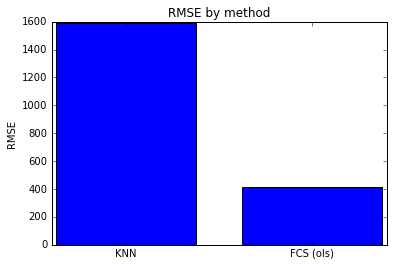

In [155]:
rmse_knn     = np.sqrt(np.sum((datahat_knn-data)**2))
rmse_fcs_lin = np.sqrt(np.sum((datahat_fcs_lin-data)**2))
# rmse_fcs_sgd = np.sqrt(np.sum((datahat_fcs_sgd-data)**2))
fig, ax = plt.subplots()
ax.bar([1,2],[rmse_knn,rmse_fcs_lin],width=0.75,color='b',align='center')
# ax.bar([1,2,3],[rmse_knn,rmse_fcs_lin,rmse_fcs_sgd],width=0.75,color='b',align='center')
ax.set_title('RMSE by method')
ax.set_ylabel('RMSE')
ax.set_xticks([1,2])
ax.set_xticklabels(('KNN', 'FCS (ols)'))
# ax.set_xticklabels(('KNN', 'FCS (ols)','FCS (sgd)'))
plt.show()

-9.34216094477e+279


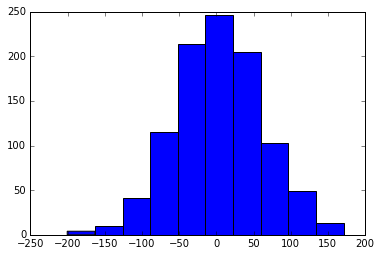

In [16]:
aa = np.random.normal(4,60,1000)
plt.hist(aa)
plt.show()
kk = stats.gaussian_kde(aa)

In [17]:
mp.cpu_count()

8